In [34]:
import h5py, numpy, matplotlib, pandas, sklearn, torch

In [ ]:
from pathlib import Path

def _listar_datasets(f):
    """Devuelve todos los paths de datasets dentro del archivo HDF5."""
    rutas = []
    def _cb(name, obj):
        if isinstance(obj, h5py.Dataset):
            rutas.append(name)
    f.visititems(_cb)
    return rutas

def load_hdf5_image_auto(file: Path):
    """
    Abre un HDF5 y devuelve una imagen 2D (np.ndarray).
    - Prefiere 'entry1/analog0/data' si existe.
    - Si no, elige el primer dataset 2D/3D razonable.
    - Si es 3D (n_im, h, w) o (h, w, n_im), toma la primera imagen.
    """
    with h5py.File(file, "r") as f:

        dsets = _listar_datasets(f)
        if not dsets:
            raise ValueError("No se encontraron datasets en el HDF5.")


        preferidos = [
            "entry1/analog0/data",
            "entry/analog0/data",
            "entry1/data",
            "entry/data",
        ]
        for p in preferidos:
            if p in f and isinstance(f[p], h5py.Dataset):
                data = np.array(f[p])
                break
        else:

            data = None
            for name in dsets:
                arr = np.array(f[name])
                if arr.ndim == 2:
                    data = arr
                    break
                if arr.ndim == 3:
                    data = arr
                    break
            if data is None:

                data = np.array(f[dsets[0]])


    if data.ndim == 2:
        return data
    if data.ndim == 3:

        axes = list(data.shape)

        stack_axis = int(np.argmin(axes))
        slicer = [slice(None)]*3
        slicer[stack_axis] = 0
        img = data[tuple(slicer)]
        if img.ndim != 2:
            img = np.squeeze(img)
            if img.ndim != 2:
                raise ValueError(f"Dataset 3D no convertible directo a 2D. shape={data.shape}")
        return img

    raise ValueError(f"Forma de datos no soportada: {data.shape}")


In [36]:
with h5py.File(files[0], "r") as f:
    rutas = []
    f.visititems(lambda name, obj: rutas.append(name) if isinstance(obj, h5py.Dataset) else None)
    for r in rutas:
        print(r, f[r].shape, f[r].dtype)


entry1/analog0/count_time (1,) float64
entry1/analog0/data (75, 75) float64
entry1/analog0/energy (1,) float64
entry1/analog0/sample_x (75,) float64
entry1/analog0/sample_y (75,) float64
entry1/analog0/stxm_scan_type (1,) |S12
entry1/collection/AnalogOut0/name (1,) |S10
entry1/collection/AnalogOut0/soft_limit_max (1,) float64
entry1/collection/AnalogOut0/soft_limit_min (1,) float64
entry1/collection/AnalogOut0/value (1,) float64
entry1/collection/Girder_Rx/controller_record (1,) |S15
entry1/collection/Girder_Rx/description (1,) |S45
entry1/collection/Girder_Rx/name (1,) |S9
entry1/collection/Girder_Rx/soft_limit_max (1,) float64
entry1/collection/Girder_Rx/soft_limit_min (1,) float64
entry1/collection/Girder_Rx/target_value (1,) float64
entry1/collection/Girder_Rx/unit (1,) |S4
entry1/collection/Girder_Rx/value (1,) float64
entry1/collection/Girder_Ry/controller_record (1,) |S13
entry1/collection/Girder_Ry/description (1,) |S45
entry1/collection/Girder_Ry/name (1,) |S9
entry1/collectio

Se encontraron 72 archivos HDF5


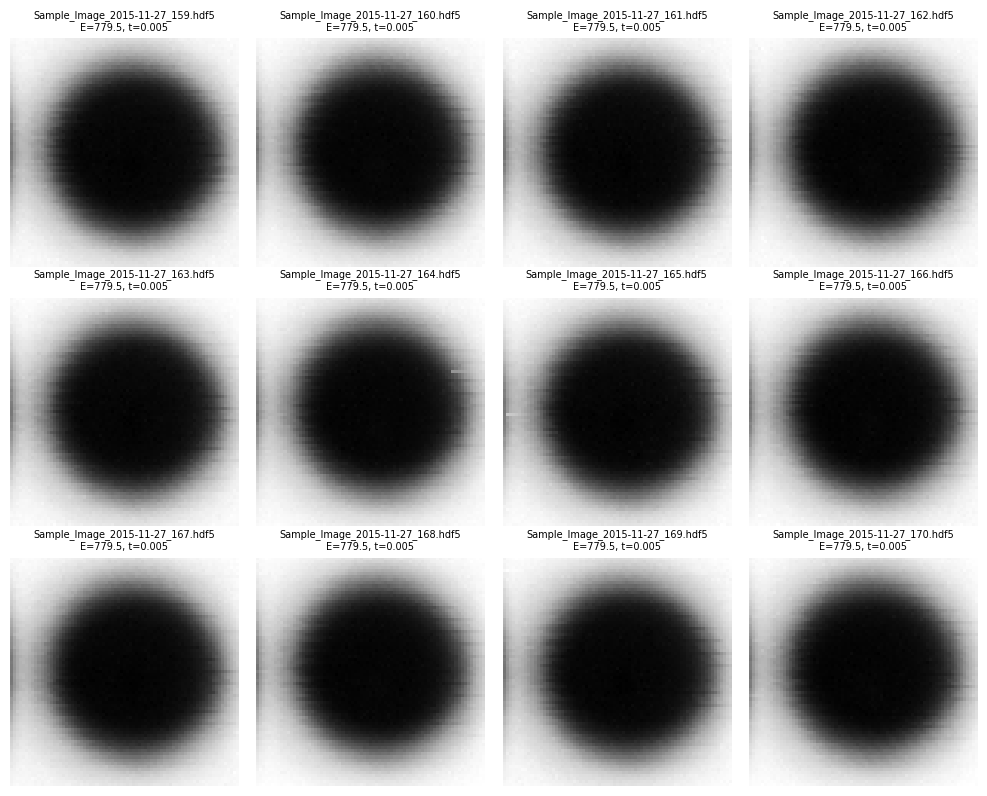

,file,energy,count_time,rotation,mean,std,min,max,x_min,x_max,y_min,y_max
0,Sample_Image_2015-11-27_159.hdf5,779.5,0.005,36.783,93599.997867,13369.081102,75293.0,113008.0,240.37383,241.85383,-1122.207478,-1120.727478
1,Sample_Image_2015-11-27_160.hdf5,779.5,0.005,36.783,92534.432533,13940.058882,73224.0,112266.0,240.37383,241.85383,-1122.207478,-1120.727478
2,Sample_Image_2015-11-27_161.hdf5,779.5,0.005,36.783,93503.821156,13282.563154,75305.0,112768.0,240.37383,241.85383,-1122.207478,-1120.727478
3,Sample_Image_2015-11-27_162.hdf5,779.5,0.005,36.783,92501.441067,13901.262660,73399.0,112271.0,240.37383,241.85383,-1122.207478,-1120.727478
4,Sample_Image_2015-11-27_163.hdf5,779.5,0.005,36.783,93433.300800,13224.325731,75216.0,112445.0,240.37383,241.85383,-1122.207478,-1120.727478


✅ Manifest guardado en ..\notebooks\xmcd_manifest.csv


In [ ]:
from pathlib import Path
import h5py, numpy as np, pandas as pd
import matplotlib.pyplot as plt

data_path = Path("../data_raw/xmcd")
files = sorted(data_path.glob("*.hdf5"))
print(f"Se encontraron {len(files)} archivos HDF5")

def read_stxm(file):
    with h5py.File(file, "r") as f:
        img = np.array(f["entry1/analog0/data"])       # (75,75)
        if img.ndim == 3: img = img[0]
        energy      = float(np.array(f["entry1/analog0/energy"])[0])
        count_time  = float(np.array(f["entry1/analog0/count_time"])[0])
        rot_angle   = float(np.array(f["entry1/sample/rotation_angle"])[0]) if "entry1/sample/rotation_angle" in f else np.nan
        x = np.array(f["entry1/analog0/sample_x"])     # (75,)
        y = np.array(f["entry1/analog0/sample_y"])     # (75,)
    return img, dict(energy=energy, count_time=count_time, rotation=rot_angle), x, y

# 1) Explorar unas cuantas
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    if i < len(files):
        img, meta, x, y = read_stxm(files[i])
        ax.imshow(img, cmap="gray", origin="lower")
        ax.set_title(f"{files[i].name}\nE={meta['energy']:.1f}, t={meta['count_time']:.3f}", fontsize=7)
        ax.axis("off")
plt.tight_layout(); plt.show()

# 2) Manifest con stats y metadatos
records = []
for f in files:
    try:
        img, meta, x, y = read_stxm(f)
        rec = {
            "file": f.name,
            "energy": meta["energy"],
            "count_time": meta["count_time"],
            "rotation": meta["rotation"],
            "mean": float(np.mean(img)),
            "std":  float(np.std(img)),
            "min":  float(np.min(img)),
            "max":  float(np.max(img)),
            "x_min": float(x.min()), "x_max": float(x.max()),
            "y_min": float(y.min()), "y_max": float(y.max()),
        }
        records.append(rec)
    except Exception as e:
        print(f" {f.name} -> {e}")

df_manifest = pd.DataFrame(records)
display(df_manifest.head())
out_csv = Path("../notebooks/xmcd_manifest.csv")
df_manifest.to_csv(out_csv, index=False)
print(" Manifest guardado en", out_csv)
